# Исследование оттока клиентов сети фитнес-центров
Цель исследования: провести анализ и подготовить план действий по удержанию клиентов сети фитнес-центров «Культурист-датасаентист». Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.

## Описание данных
Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `Churn` — факт оттока в текущем месяце.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-0">Описание данных</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1">Загрузка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных-(EDA)-и-предобработка" data-toc-modified-id="Исследовательский-анализ-данных-(EDA)-и-предобработка-2">Исследовательский анализ данных (EDA) и предобработка</a></span></li><li><span><a href="#Построение-модели-прогнозирования-оттока-клиентов" data-toc-modified-id="Построение-модели-прогнозирования-оттока-клиентов-3">Построение модели прогнозирования оттока клиентов</a></span></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-4">Кластеризация клиентов</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5">Общий вывод</a></span></li></ul></div>

## Загрузка данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # снимаем ограничение на количество столбцов
pd.set_option('display.max_colwidth', None) # снимаем ограничение на ширину столбцов

In [2]:
# функция отображения основной информации
def info_func(table):
    display(table.head().T)
    display(table.info())
    display(table.nunique())
    print('Явных дубликатов:',table.duplicated().sum())
    display(table.describe())

In [3]:
churn = pd.read_csv('/datasets/gym_churn.csv') # загрузка файла
churn

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0          1              1        1              1      0                6   
1          0              1        0              0      1               12   
2          0              1        1              0      1                1   
3          0              1        1              1      1               12   
4          1              1        1              1      1                1   
...      ...            ...      ...            ...    ...              ...   
3995       1              1        1              0      1               12   
3996       0              1        0              0      1                1   
3997       1              1        1              1      1               12   
3998       0              1        1              1      1                6   
3999       1              0        1              0      0               12   

      Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0                1   29                     14.227470                    5.0   
1                1   31                    113.202938                   12.0   
2                0   28                    129.448479                    1.0   
3                1   33                     62.669863                   12.0   
4                0   26                    198.362265                    1.0   
...            ...  ...                           ...                    ...   
3995             0   33                      2.406023                   12.0   
3996             1   29                     68.883764                    1.0   
3997             0   28                     78.250542                   11.0   
3998             0   32                     61.912657                    5.0   
3999             1   30                    178.861814                   12.0   

      Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0            3                   0.020398                           0.000000   
1            7                   1.922936                           1.910244   
2            2                   1.859098                           1.736502   
3            2                   3.205633                           3.357215   
4            3                   1.113884                           1.120078   
...        ...                        ...                                ...   
3995         8                   2.284497                           2.349070   
3996         1                   1.277168                           0.292859   
3997         2                   2.786146                           2.831439   
3998         3                   1.630108                           1.596237   
3999         1                   1.101832                           1.035270   

      Churn  
0         0  
1         0  
2         0  
3         0  
4         0  
...     ...  
3995      0  
3996      1  
3997      0  
3998      0  
3999      0  

[4000 rows x 14 columns]

Файл с данными и все необходимые библиотеки были успешно загружены. Данные содержатся в таблице 4000 строк и 14 столбцов.

## Исследовательский анализ данных (EDA) и предобработка

In [4]:
info_func(churn) # отображение основной информации

0           1           2  \
gender                              1.000000    0.000000    0.000000   
Near_Location                       1.000000    1.000000    1.000000   
Partner                             1.000000    0.000000    1.000000   
Promo_friends                       1.000000    0.000000    0.000000   
Phone                               0.000000    1.000000    1.000000   
Contract_period                     6.000000   12.000000    1.000000   
Group_visits                        1.000000    1.000000    0.000000   
Age                                29.000000   31.000000   28.000000   
Avg_additional_charges_total       14.227470  113.202938  129.448479   
Month_to_end_contract               5.000000   12.000000    1.000000   
Lifetime                            3.000000    7.000000    2.000000   
Avg_class_frequency_total           0.020398    1.922936    1.859098   
Avg_class_frequency_current_month   0.000000    1.910244    1.736502   
Churn                               0.000000    0.000000    0.000000   

                                           3           4  
gender                              0.000000    1.000000  
Near_Location                       1.000000    1.000000  
Partner                             1.000000    1.000000  
Promo_friends                       1.000000    1.000000  
Phone                               1.000000    1.000000  
Contract_period                    12.000000    1.000000  
Group_visits                        1.000000    0.000000  
Age                                33.000000   26.000000  
Avg_additional_charges_total       62.669863  198.362265  
Month_to_end_contract              12.000000    1.000000  
Lifetime                            2.000000    3.000000  
Avg_class_frequency_total           3.205633    1.113884  
Avg_class_frequency_current_month   3.357215    1.120078  
Churn                               0.000000    0.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

gender                                  2
Near_Location                           2
Partner                                 2
Promo_friends                           2
Phone                                   2
Contract_period                         3
Group_visits                            2
Age                                    23
Avg_additional_charges_total         4000
Month_to_end_contract                  12
Lifetime                               29
Avg_class_frequency_total            3913
Avg_class_frequency_current_month    3820
Churn                                   2
dtype: int64

Явных дубликатов: 0


gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       Avg_additional_charges_total  Month_to_end_contract     Lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       Avg_class_frequency_total  Avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             Churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [5]:
for column in churn.columns:
    print(column)
    print(churn[column].unique())
    print()

gender
[1 0]

Near_Location
[1 0]

Partner
[1 0]

Promo_friends
[1 0]

Phone
[0 1]

Contract_period
[ 6 12  1]

Group_visits
[1 0]

Age
[29 31 28 33 26 34 32 30 23 27 35 25 36 24 21 37 22 19 20 38 39 18 41]

Avg_additional_charges_total
[ 14.22747042 113.20293765 129.44847933 ...  78.25054157  61.91265691
 178.86181361]

Month_to_end_contract
[ 5. 12.  1.  6.  3. 10. 11.  9.  4.  7.  8.  2.]

Lifetime
[ 3  7  2  0  1 11  4  8 14  6  5 15 12 21 10 20  9 13 17 16 24 22 31 26
 23 18 19 27 29]

Avg_class_frequency_total
[0.02039795 1.92293606 1.85909835 ... 2.78614636 1.63010814 1.10183221]

Avg_class_frequency_current_month
[0.         1.91024352 1.73650189 ... 2.8314395  1.59623664 1.03526976]

Churn
[0 1]



In [6]:
categoriсal_1 = ['gender', 'Near_Location', 'Partner', 'Promo_friends', \
                'Phone', 'Contract_period', 'Group_visits', 'Churn']

In [7]:
number_1 = ['Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', \
                'Avg_class_frequency_total', 'Avg_class_frequency_current_month']

In [8]:
# устанавливаем стиль графиков
sns.set_style('whitegrid')
sns.set_palette('brg')

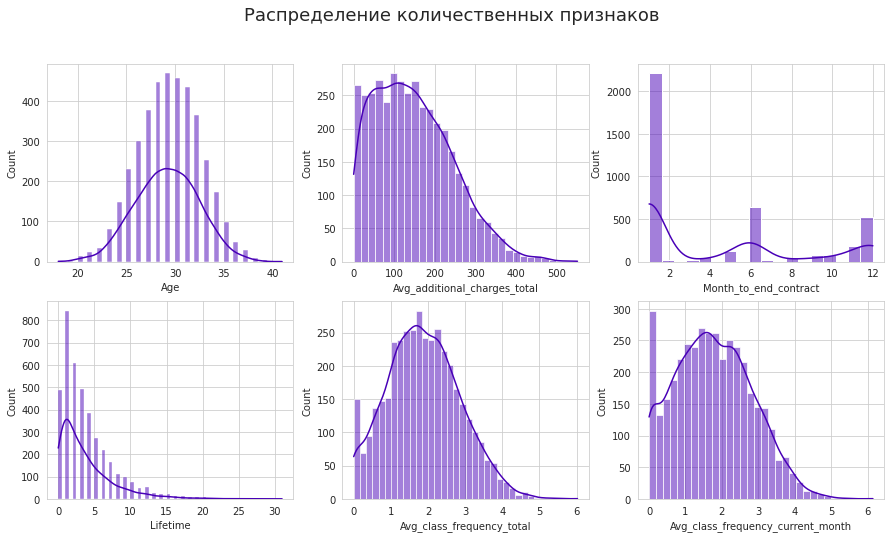

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax=ax.ravel()
fig.suptitle('Распределение количественных признаков', fontsize = 18)
for i in range(len(number_1)):
    sns.histplot(churn, x=churn[number_1[i]], ax=ax[i], kde=True)
plt.show()

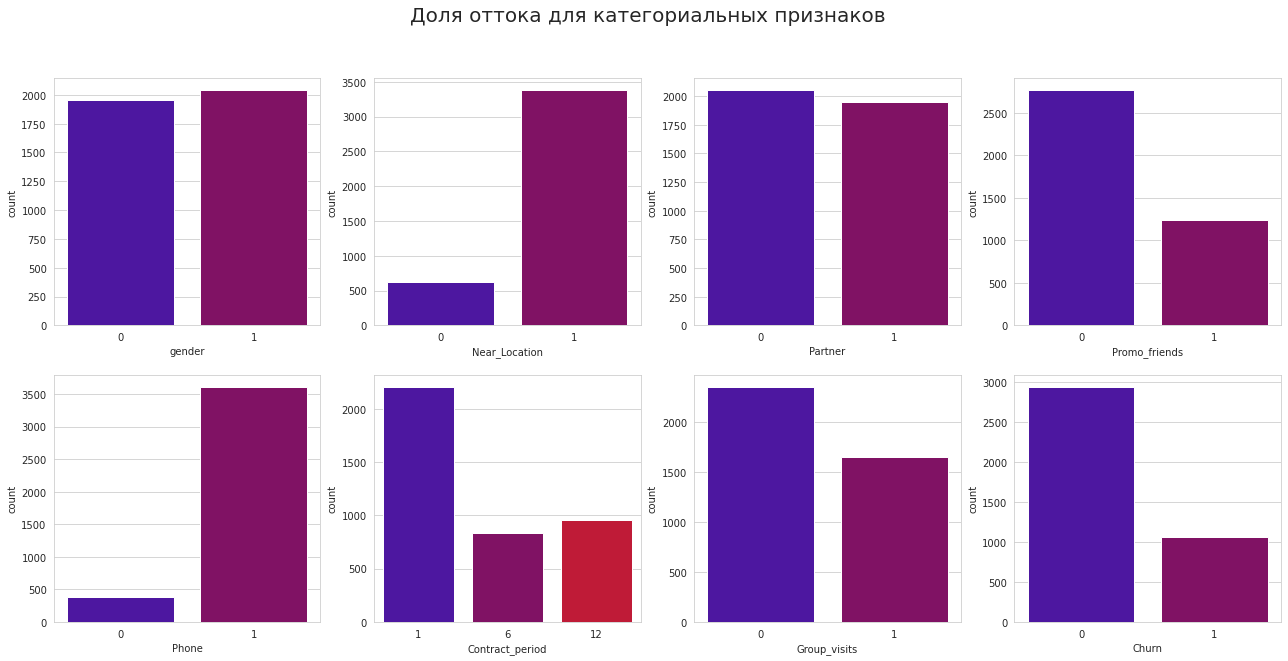

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle('Доля оттока для категориальных признаков', fontsize = 20)
ax=ax.ravel()
for i in range(len(categoriсal_1)):
    sns.countplot(data=churn, x=categoriсal_1[i], ax=ax[i])
plt.show()

В загруженной таблице нет пропусков и явных дубликатов, половина столбцов имеет значения 0 или 1. Названия столбцов не соответствуют naming convention.

Распределение клиентов по полу примерно одинаковое. Абонементы имеют сроки в 1, 6 и 12 месяцев, а возраст клиентов разбросан от 19 до 41 года и напоминает нормальное распределение. Средний возраст клиентов - 29 лет. Самые первые клиенты клуба, находящиеся в базе, были зарегистрированы 29 месяцев назад. Средняя длительность абонементов клиентов - менее полугода.

Со временем всё больше клиентов обращается в фитнес-центр (судя по распределению лайфтайма). Большинство клиентов посещает фитнес-центр 2-3 раза в неделю. Оставшиеся пользователи чаще ходят на групповые занятия. Доля оттока - 27%.

Большая часть клиентов живет или работает рядом с фитнес-клубом. Примерно половина клиентов являются сотрудниками партнерских организаций.

In [11]:
# приведем название столбцов к нижнему регистру 
churn.columns = churn.columns.str.lower()

In [12]:
churn['month_to_end_contract'] = churn['month_to_end_contract'].astype('int') # исправим тип данных

Успешно завершены этапы предобработки данных.

In [13]:
churn.groupby('churn').agg('mean').T

churn                                       0           1
gender                               0.510037    0.510839
near_location                        0.873086    0.768143
partner                              0.534195    0.355325
promo_friends                        0.353522    0.183789
phone                                0.903709    0.902922
contract_period                      5.747193    1.728558
group_visits                         0.464103    0.268615
age                                 29.976523   26.989632
avg_additional_charges_total       158.445715  115.082899
month_to_end_contract                5.283089    1.662582
lifetime                             4.711807    0.990575
avg_class_frequency_total            2.024876    1.474995
avg_class_frequency_current_month    2.027882    1.044546

По факту оттока распределение по полу примерно одинаковое, а близко живущие или работающие клиенты реже попадают в отток. Сотрудники компаний-партнеров реже перестают посещать фитнесс-клуб, чем остальные клиенты. Клиенты, пришедшие по акции "Приведи друга" в два раза реже уходят. Средняя длительность договора больше у оставшихся пользователей. У ушедших клиентов меньше среднее количество посещений в неделю за всё время.

In [14]:
categoriсal = ['gender', 'near_location', 'partner', 'promo_friends', \
                'phone', 'contract_period', 'group_visits', 'churn']

In [15]:
number = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', \
                'avg_class_frequency_total', 'avg_class_frequency_current_month']

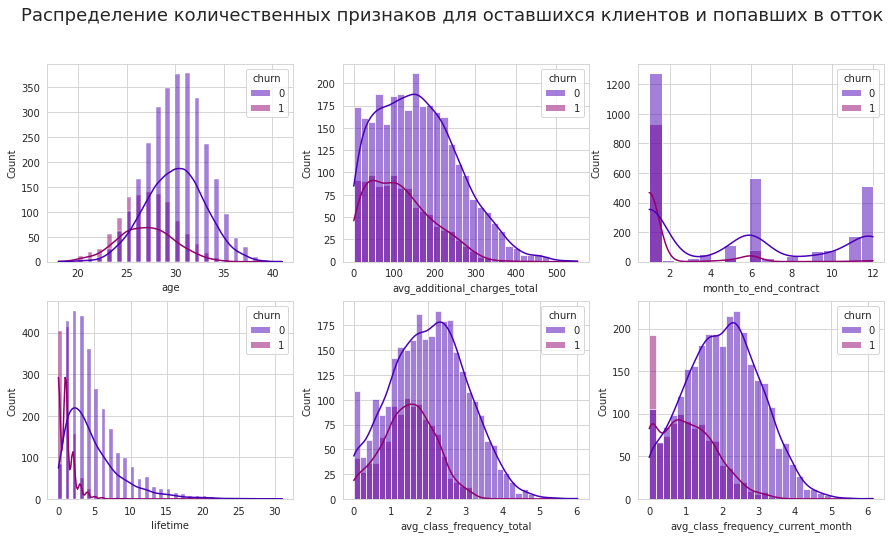

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax=ax.ravel()
fig.suptitle('Распределение количественных признаков для оставшихся клиентов и попавших в отток', fontsize = 18)
for i in range(len(number)):
    sns.histplot(churn, x=churn[number[i]], hue='churn', ax=ax[i], kde=True)
plt.show()

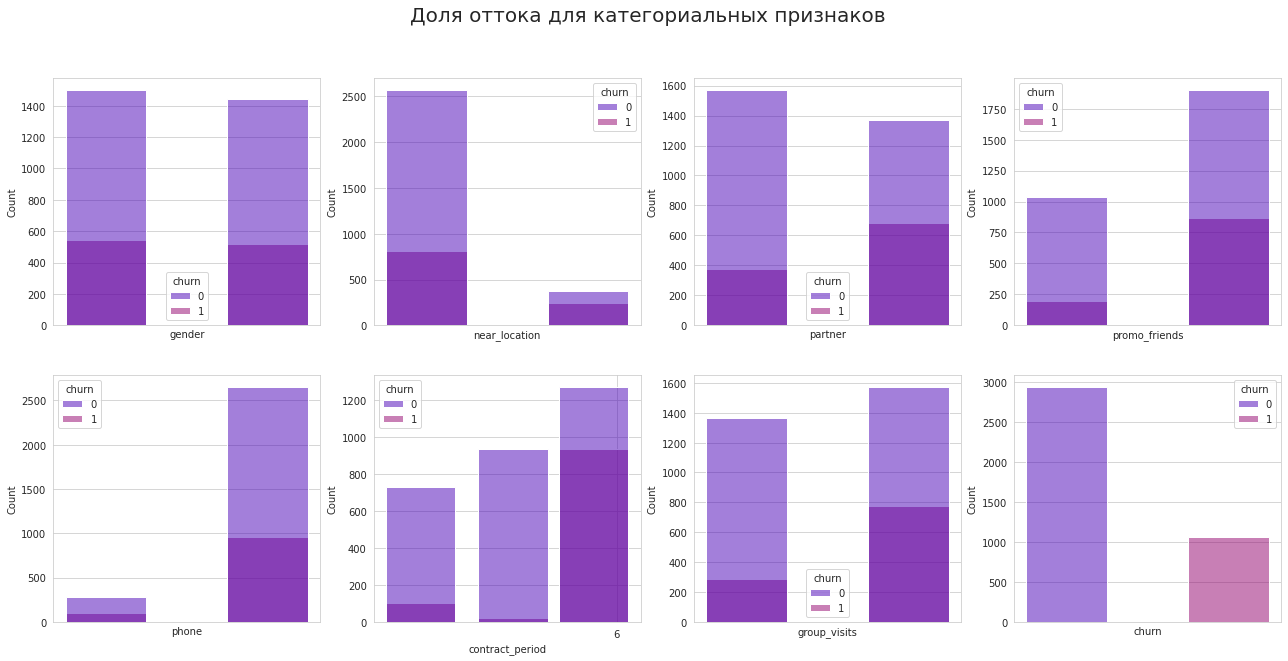

In [17]:
churn[categoriсal] = churn[categoriсal].astype('str')
fig, ax = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle('Доля оттока для категориальных признаков', fontsize = 20)
ax=ax.ravel()
for i in range(len(categoriсal)):
    sns.histplot(churn, x=categoriсal[i], hue='churn', ax=ax[i], discrete=False, shrink=6)
plt.show()

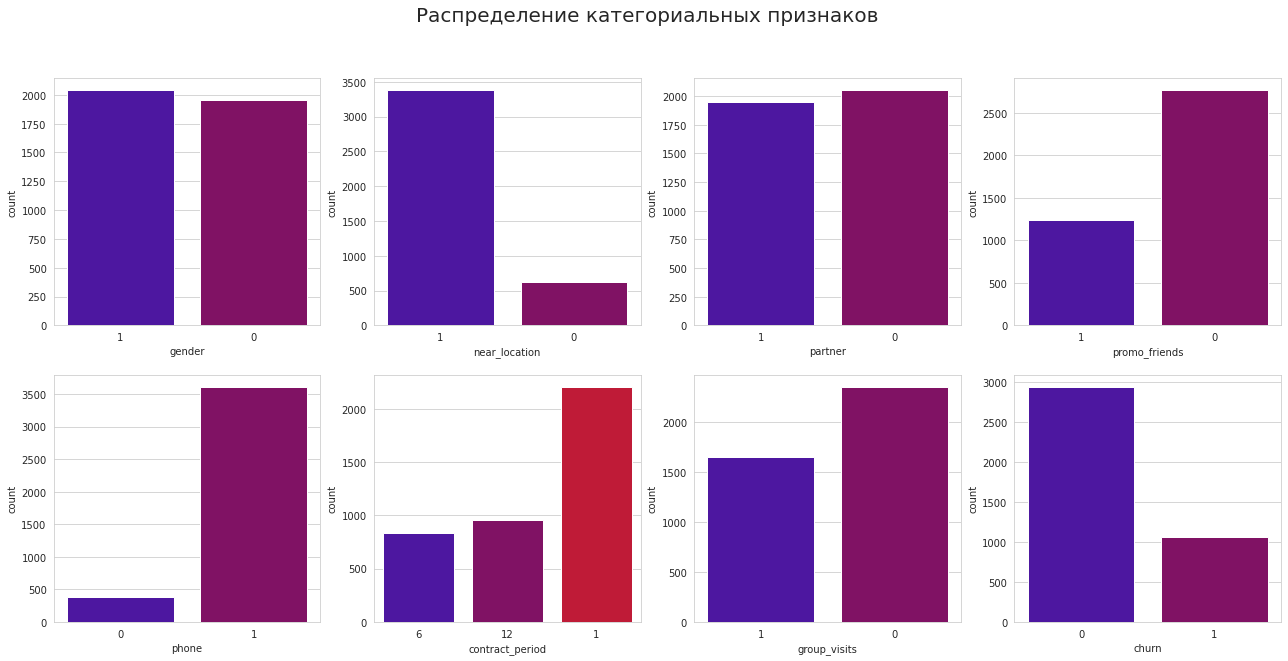

In [18]:
fig, ax = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle('Распределение категориальных признаков', fontsize = 20)
ax=ax.ravel()
for i in range(len(categoriсal)):
    sns.countplot(data=churn, x=categoriсal[i], ax=ax[i])
plt.show()

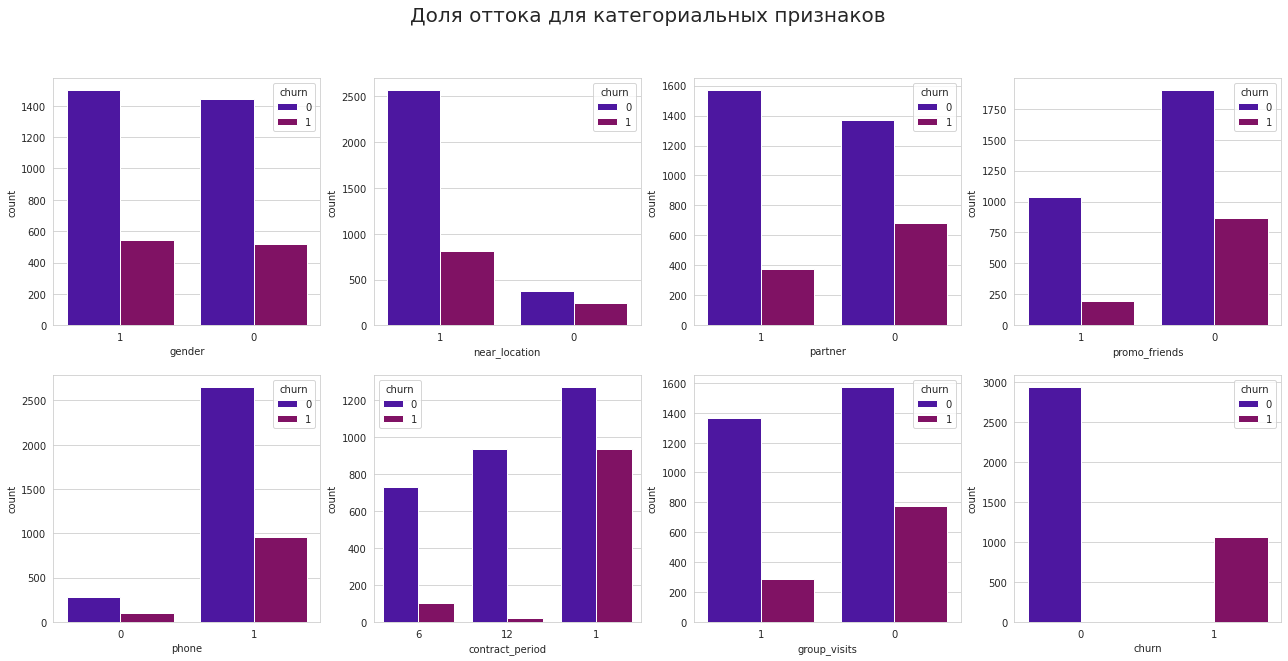

In [19]:
fig, ax = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle('Доля оттока для категориальных признаков', fontsize = 20)
ax=ax.ravel()
for i in range(len(categoriсal)):
    sns.countplot(data=churn, x=categoriсal[i], hue='churn', ax=ax[i])
plt.show()

In [20]:
# обратно переведем значения категориальных признаков к формату int
churn[categoriсal] = churn[categoriсal].astype('int')

Чем дольше действует абонемент, тем меньше людей покидает клуб. Среди людей до 27 лет клиенты чаще уходят, чем остаются. Ушедшие клиенты потратили на доп. услуги в среднем меньше 100 д.е.

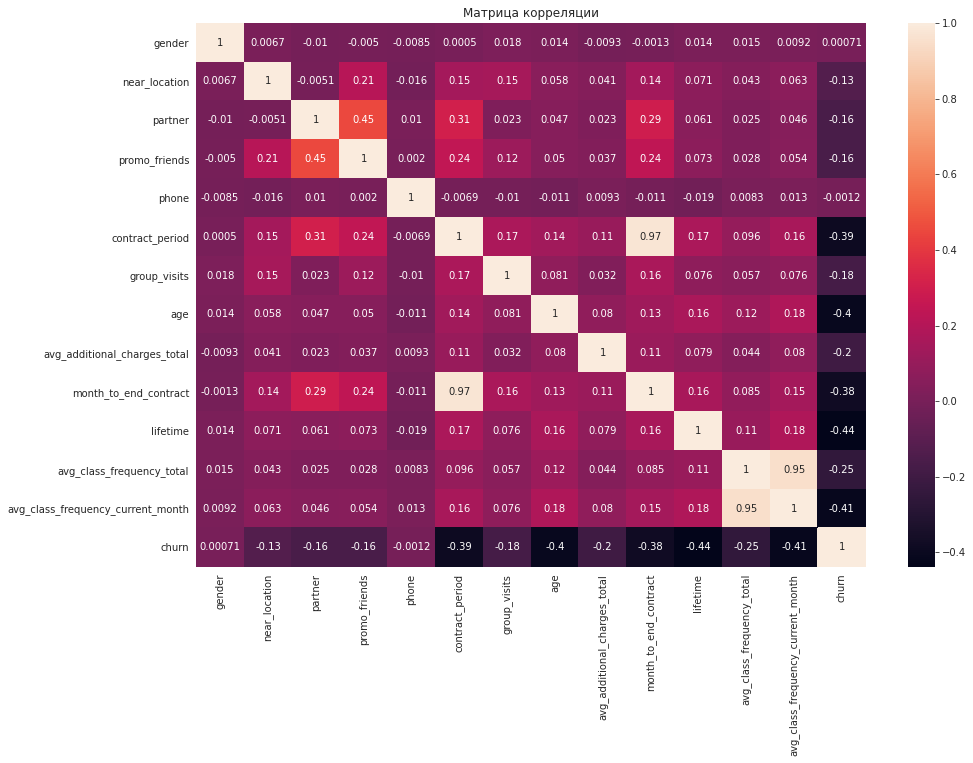

In [21]:
correl = churn.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correl, annot = True)
plt.title('Матрица корреляции')
plt.show()

Согласно матрице корреляцей, нет сильной взаимосвязи переменных с фактом оттока.

Заметна сильная положительная корреляция между числом месяцев до окончания действия абонемента и периодом действия абонемента, а также между общей частотой посещения в неделю и частотой посещения в неделю за последний месяц. Слабее корреляция между акциями парнёрской программы и акции "Приведи друга".

Нулевая корреляция с целевой переменной у факта наличия номера телефона и пола.

Слабая отрицательная корреляция с целевой переменной у времени с момента первого обращения в фитнес-центр (в месяцах), частотой посещения зала, возраста, времени действия абонемента и средней суммы, которую платили клиенты за доп. услуги. С остальными переменными корреляция ещё слабее.

## Построение модели прогнозирования оттока клиентов

In [22]:
X = churn.drop('churn', axis = 1)
y = churn['churn']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0) # разбиение данных по выборкам

In [24]:
scaler = StandardScaler() # стандартизация данных
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [25]:
# функция вывода метрик моделей
def show_metrics(name, mdl):
    mdl.fit(X_train_st, y_train)
    y_pred = mdl.predict(X_test_st)
    print("Model -", name)
    print('Mean of target variable: {:.2f}'.format(y_test.mean()))
    acc = accuracy_score(y_test, y_pred)
    print("accuracy =",acc.round(3))
    precision = precision_score(y_test, y_pred).round(3)
    print("precision =", precision)
    recall = recall_score(y_test, y_pred).round(3)
    print("recall =", recall)
    f_1 = f1_score(y_test, y_pred).round(3)
    print("f1 score =", f_1, '\n')
# модель логистической регрессии
model_log = LogisticRegression(solver='liblinear', random_state=0)
show_metrics('"LogisticRegression"', model_log)
# модель случайного леса
model_rfc = RandomForestClassifier(n_estimators = 100, random_state=0)
show_metrics('"RandomForest"', model_rfc)

Model - "LogisticRegression"
Mean of target variable: 0.25
accuracy = 0.922
precision = 0.854
recall = 0.828
f1 score = 0.841 

Model - "RandomForest"
Mean of target variable: 0.25
accuracy = 0.915
precision = 0.839
recall = 0.813
f1 score = 0.826 



Согласно метрикам точности и полноты прогнозов, модель логистической регресии показывает себя лучше, чем модель случайного леса. По обеим моделям прогнозная вероятность оттока составляет 25%.

## Кластеризация клиентов

In [26]:
# стандартизация данных
sc = StandardScaler()
X_sc = sc.fit_transform(X) 

In [27]:
linked = linkage(X_sc, method = 'ward') # таблица «связок» между объектами (матрица расстояний)

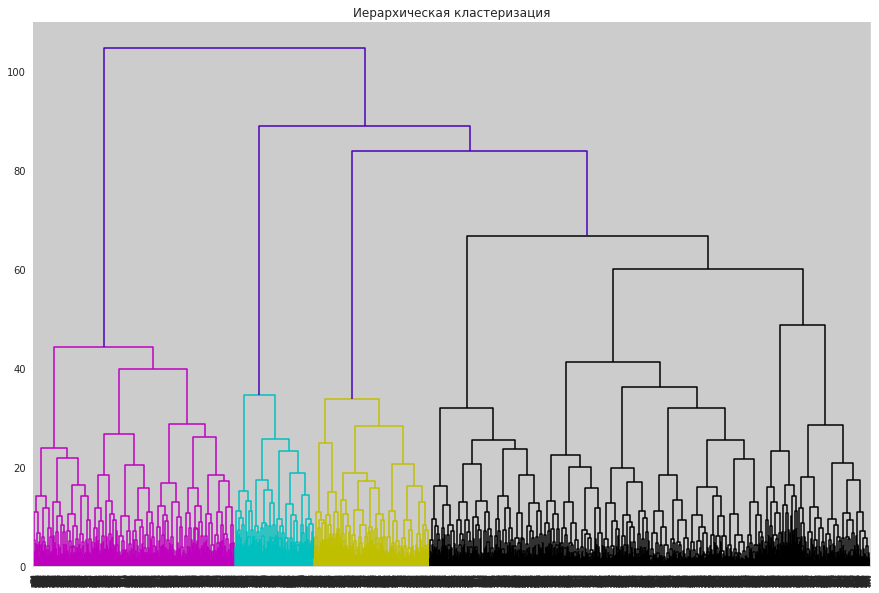

In [28]:
plt.figure(figsize=(15, 10))  
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
dendrogram(linked, orientation='top') # дендрограмма
plt.title('Иерархическая кластеризация')
plt.show()

Согласно иерархической кластеризации, было выявлено 4 кластера.

In [29]:
km = KMeans(n_clusters = 5, random_state=0) # укажем 5 кластеров
labels = km.fit_predict(X_sc) 

In [30]:
churn['cluster_km'] = labels
churn.T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

In [31]:
churn['cluster_km'].value_counts()

3    1262
0    1010
4     838
2     505
1     385
Name: cluster_km, dtype: int64

Больше всего клиентов попадает в кластер "3" и "0", а меньше всего - в кластер "1".

In [32]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.14


Метрика силуэта больше нуля, что не так плохо.

In [33]:
churn.groupby('cluster_km').mean().T

cluster_km                                  0           1           2  \
gender                               0.502970    0.522078    0.495050   
near_location                        0.959406    0.862338    0.000000   
partner                              0.783168    0.470130    0.463366   
promo_friends                        0.574257    0.306494    0.079208   
phone                                1.000000    0.000000    1.000000   
contract_period                     10.889109    4.787013    2.352475   
group_visits                         0.542574    0.425974    0.215842   
age                                 29.982178   29.301299   28.477228   
avg_additional_charges_total       160.761016  143.957664  135.457501   
month_to_end_contract                9.954455    4.475325    2.198020   
lifetime                             4.736634    3.924675    2.809901   
avg_class_frequency_total            1.982055    1.847220    1.660461   
avg_class_frequency_current_month    1.974789    1.716369    1.477324   
churn                                0.027723    0.267532    0.443564   

cluster_km                                  3           4  
gender                               0.485737    0.559666  
near_location                        1.000000    0.976134  
partner                              0.350238    0.356802  
promo_friends                        0.240095    0.230310  
phone                                1.000000    0.998807  
contract_period                      1.948494    2.669451  
group_visits                         0.341521    0.473747  
age                                 28.167987   30.125298  
avg_additional_charges_total       131.622204  161.657905  
month_to_end_contract                1.856577    2.459427  
lifetime                             2.440571    4.898568  
avg_class_frequency_total            1.247634    2.852002  
avg_class_frequency_current_month    1.012983    2.850161  
churn                                0.514263    0.068019

Кластер 0: Отток - 3% - самый низкий. Живут или работают недалеко от фитнес-центра. Преобладают сотрудники компаний-партнеров. Чаще всех пришли по промо акции. Заключают договоры на длительный срок - 12 месяцев. Чаще всех посещают групповые занятия. 

Кластер 1: Отток - 27%. Живут или работают недалеко от фитнес-центра. Нет мобильного номера. В среднем абонементы на 4.5 месяцев.

Кластер 2: Отток - 44%. Похожи на кластер 0, но живут или работают в другом районе и почти не являются участниками акции "Приведи друга". Реже всех посещают групповые занятия.

Кластер 3: Отток - 51% - самый высокий. Живут или работают недалеко от фитнес-центра. В основном, обладатели недолгосрочных абонементов на 1-3 месяца. Наименьшее кол-во посещений за всё время и в последний месяц. В среднем. меньше всех потратили денег на доп. услуги.

Кластер 4: Отток - 7%. Живут или работают недалеко от фитнес-центра. Чаще всех посещают клуб. Договоры не на длительный срок - в среднем 2.8 месяцев. Часто ходили на групповые занятия. Больше всех потратили денег на доп. услуги.

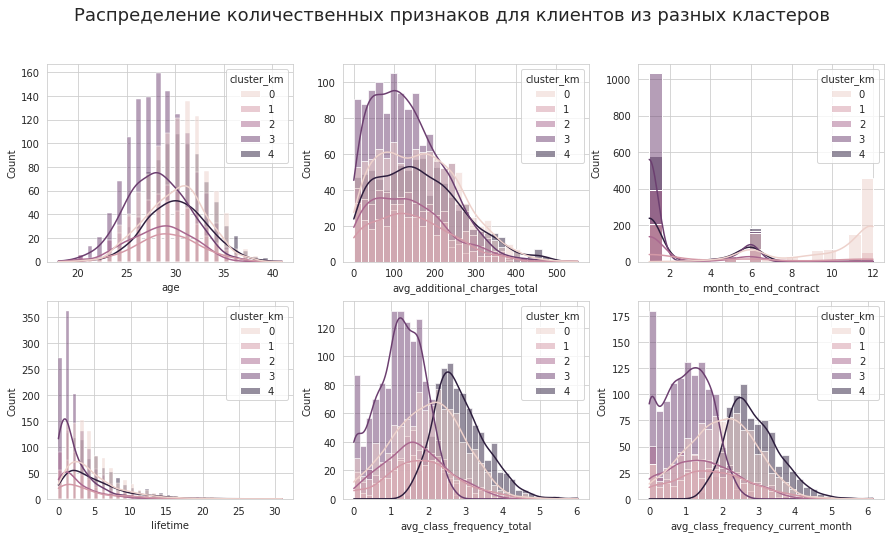

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax=ax.ravel()
fig.suptitle('Распределение количественных признаков для клиентов из разных кластеров', fontsize = 18)
for i in range(len(number)):
    sns.histplot(data=churn, x=churn[number[i]], hue = 'cluster_km', ax=ax[i], kde=True)
plt.show()

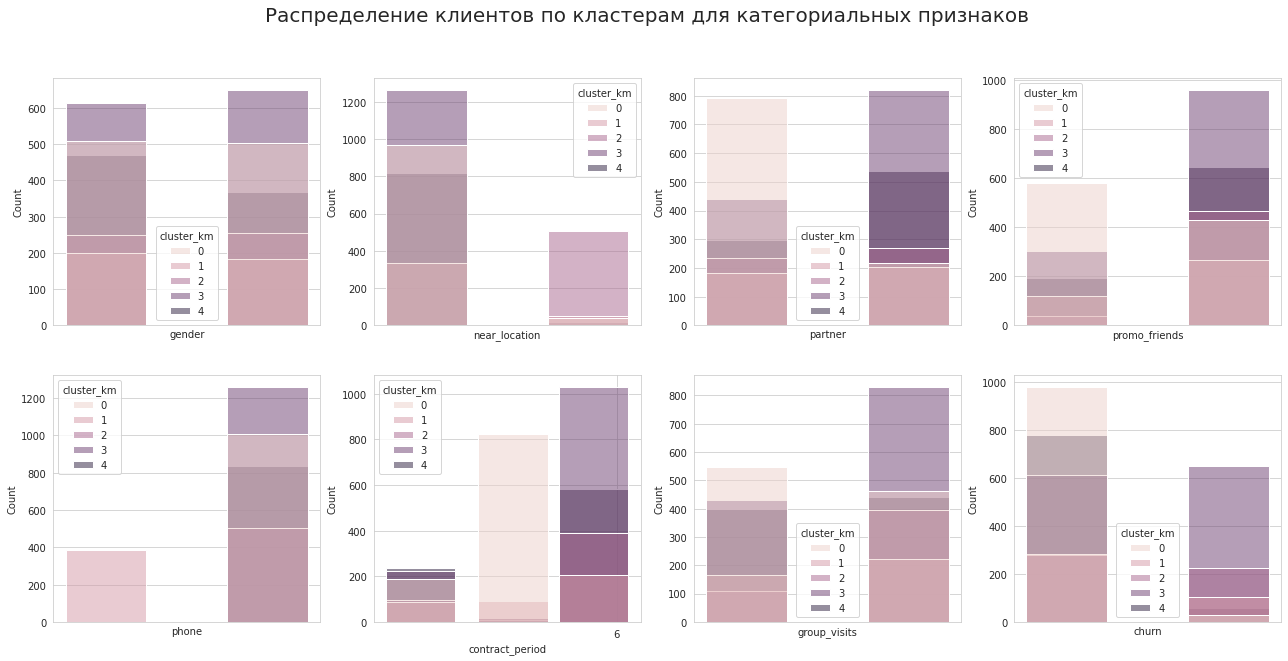

In [35]:
churn[categoriсal] = churn[categoriсal].astype('str')
fig, ax = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle('Распределение клиентов по кластерам для категориальных признаков', fontsize = 20)
ax=ax.ravel()
for i in range(len(categoriсal)):
    sns.histplot(churn, x=categoriсal[i], hue='cluster_km', ax=ax[i], discrete=False, shrink=6)
plt.show()

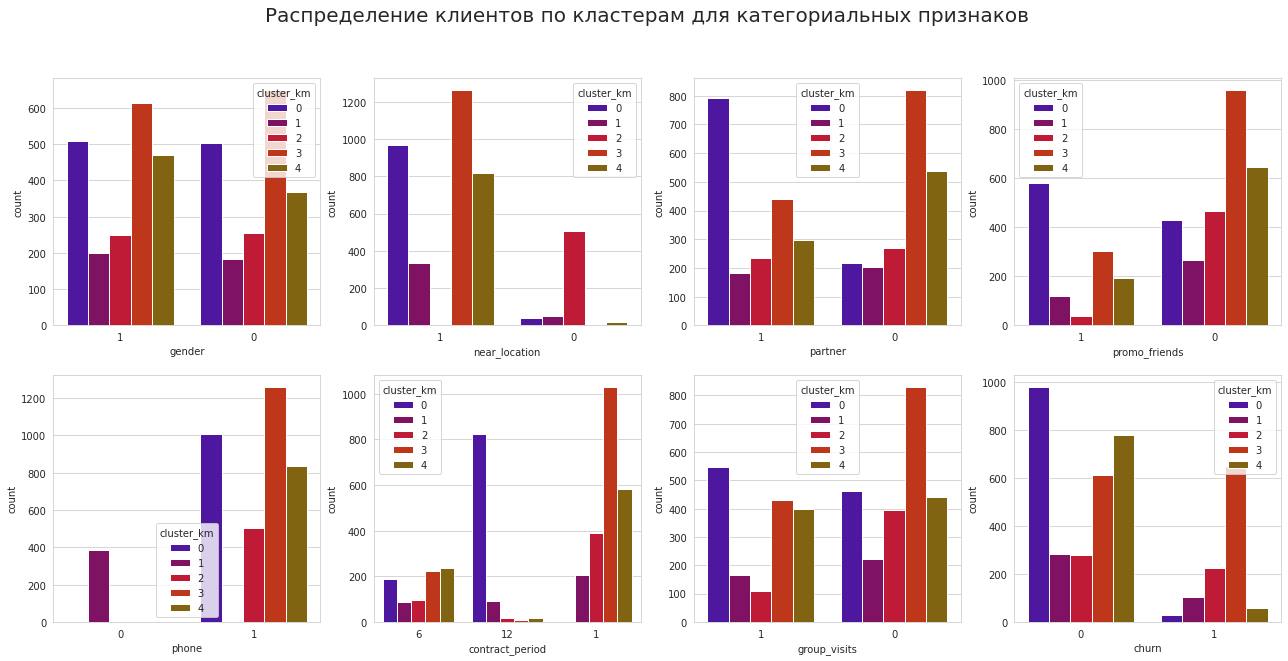

In [36]:
fig, ax = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle('Распределение клиентов по кластерам для категориальных признаков', fontsize = 20)
ax=ax.ravel()
for i in range(len(categoriсal)):
    sns.countplot(data=churn, x=categoriсal[i], hue='cluster_km', ax=ax[i])
plt.show()

In [37]:
# обратно переведем значения категориальных признаков к формату int
churn[categoriсal] = churn[categoriсal].astype('int')

Много представителей 0 кластера старше 30 лет, а по категориям до 30 лет - больше всего представителей 3 кластера.

Представители 4 кластера чаще других фитнес-центр. Лидерство по продолжительным абонементам у 0 кластера. 

По средним расходам на доп. услуги выше 200 д.е. в лидерах 0 и 4 кластеры, а по более дешёвым услугам - 3 кластер.

In [38]:
print('Данные в процентах по доле ушедших клиентов по кластерам')
round(churn.query('churn==1').groupby('cluster_km')['churn'].count() / churn.query('churn==1')['churn'].count(), 4) * 100

Данные в процентах по доле ушедших клиентов по кластерам


cluster_km
0     2.64
1     9.71
2    21.11
3    61.17
4     5.37
Name: churn, dtype: float64

В разрезе общего числа ушедших клиентов наибольшая доля ушедших клиентов принадлежит кластеру 3, в 3 раза меньше доля по кластеру 2. Меньше всего доля по кластеру 0.

## Общий вывод

Для анализа были предоставлены данные о клиентах сети фитнес-центров. Исходя из качества данных, потребовалась минимальная предобработка. Все типы данных достаточно удобны для дальнейшего анализа и прогноза.

Распределение клиентов по полу примерно одинаковое. Абонементы имеют сроки в 1, 6 и 12 месяцев, а возраст клиентов разбросан от 19 до 41 года и напоминает нормальное распределение. Средний возраст клиентов - 29 лет. Самые первые клиенты клуба, находящиеся в базе, были зарегистрированы 29 месяцев назад. Средняя длительность абонементов клиентов - менее полугода.

Со временем всё больше клиентов обращается в фитнес-центр (судя по распределению лайфтайма). Большинство клиентов посещает фитнес-центр 2-3 раза в неделю. Оставшиеся пользователи чаще ходят на групповые занятия. Доля оттока - 27%.

Большая часть клиентов живет или работает рядом с фитнес-клубом. Примерно половина клиентов являются сотрудниками партнерских организаций.

*По факту оттока распределение по полу примерно одинаковое, а близко живущие или работающие клиенты реже попадают в отток. Сотрудники компаний-партнеров реже перестают посещать фитнесс-клуб, чем остальные клиенты. Клиенты, пришедшие по акции "Приведи друга" в два раза реже уходят. Средняя длительность договора больше у оставшихся пользователей. У ушедших клиентов меньше среднее количество посещений в неделю за всё время.*

*Чем дольше действует абонемент, тем меньше людей покидает клуб. Среди людей до 27 лет клиенты чаще уходят, чем остаются. Ушедшие клиенты потратили на доп. услуги в среднем меньше 100 д.е.*

Нет сильной взаимосвязи переменных с фактом оттока.

Заметна сильная положительная корреляция между числом месяцев до окончания действия абонемента и периодом действия абонемента, а также между общей частотой посещения в неделю и частотой посещения в неделю за последний месяц. Слабее корреляция между акциями парнёрской программы и акции "Приведи друга".

Нулевая корреляция с целевой переменной у факта наличия номера телефона и пола.

Слабая отрицательная корреляция с целевой переменной у времени с момента первого обращения в фитнес-центр (в месяцах), частотой посещения зала, возраста, времени действия абонемента и средней суммы, которую платили клиенты за доп. услуги. С остальными переменными корреляция ещё слабее.

Согласно метрикам точности и полноты прогнозов, модель логистической регресии показывает себя лучше, чем модель случайного леса. По обеим моделям прогнозная вероятность оттока составляет 25%.

---

**Были сформированы кластеры клиентов с определёнными отличительными чертами, на бызе которых составлены портреты целевой аудитории.**

* Кластер 0: Отток - 3% - самый низкий. В него попали самые активные и заинтересованные клиенты, живущие не далеко, которые часто ищут акции, пытаются сэкономить (абонементы на год дешевле, чем плата 2 раза за абонементы в 6 месяцев или 12 раз за месячные абонементы) и у них это получается. Они берут всё от предоставляемых услуг.


* Кластер 1: Отток - 27%. Похожи на кластер 0, но не предоставили номер телефона и срок абонементов короче. Реже чем кластер 0, но чаще, чем кластер 2 участвуют в акциях. Возможно, у них такой ритм жизни, что они то готовы ходить и получать результаты, то что-то случается, и они пропадают.


* Кластер 2: Отток - 44%. Похожи на кластер 0, но живут или работают в другом районе и почти не являются участниками акции "Приведи друга". Реже всех посещают групповые занятия. Они хотят хорошие результаты, но удалённость от зала и отсутствие привязанности к расписанию групповых занятий мешает им дисциплинированно посещать занятия.


* Кластер 3: Отток - 51% - самый высокий. Здесь расположились те, кто "пытается начать жизнь с понедельника". Вроде и живут или работают недалеко от фитнес-центра, но ходят редко, лишний раз деньги не тратят на доп услуги или более продолжительный по времени абонемент из-за неуверенности в своих силах.


* Кластер 4: Отток - 7%. Здесь более уверенные в своих силах и желающие за короткий срок добиться максимальных результатов.

В разрезе общего числа ушедших клиентов наибольшая доля ушедших клиентов принадлежит кластеру 3, в 3 раза меньше доля по кластеру 2. Меньше всего доля по кластеру 0.

<div style="border:solid black 2px; padding: 10px"> 

**Рекомендации**
    
- Модель регрессии неплохо себя показала, а значит готова к построению прогнозов.
- Необходимо использовать кластеризацию для особых предложений клиентам с целью повышения лояльности, например:
    * на опыте кластера 1 можно предложить скидки на абонементы на 6 месяцев для всех, чей номер телефона есть в базе;
    * на опыте кластера 2 можно скорректировать время работы клуба, чтобы каждый мог успеть на занятие (оптимальные окна узнать из опроса-рассылки);
    * на опыте кластера 3 можно предложить 1 бесплатую тренировку с тренерами; тренеры будут завлекать клиентов на дальнейшее посещение.
- Исходя из информации о более редком посещении зала ушедшими людьми, можно повысить мотивацию клиентов, создав "комьюнити" в социальных сетях с мотивационными постами.
    
    